# Computation of the Lindemann parameter 

The Lindemann parameter is very useful in detecting first order transition. It is computed from the equation $δ=\frac{2}{N(N-1)}  \sum\limits_{j=1}^{N-1}  \sum\limits_{j=i+1}^N \frac{\sqrt{〈r_{ij}^2 〉_t-〈r_{ij} 〉_t^2}}{〈r_{ij} 〉} $ where N is the number of particles in the system, $<...>_t$ denotes time averaging and $r_{ij}$ is the distance between the $i^{th}$ and the $j^{th}$ particle.

The first step is to create a list with the names of the files that will be processed. I assume that each file corresponds to a different temperature

In [1]:
dump_files = []
for i in range(1, 33):
  dump_files.append("dump.atom_{}00.gz".format(i))

The second step is to create a list with the temperatures

In [2]:
temperature_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200]

I assume that the number of configurations is fixed and it is the same in all dump files

In [3]:
nconfs = 1001

I should import some useful modules first

In [5]:
%matplotlib inline

import gzip
import numpy
import matplotlib.pyplot as plt

The following function reads a single configuration from a dump file that has been generated by LAMMPS using the "atom/gz" format in the dump command 

In [6]:
# this is a function to read configurations from the dump files - it should be replaced by a call to PyLammps
def read_dump_file(input_file):

    box = numpy.zeros(3)

    input_file.readline()
    input_file.readline()
    input_file.readline()
    natoms = int(input_file.readline().split()[0])
    input_file.readline()
    lx = input_file.readline().split()
    ly = input_file.readline().split()
    lz = input_file.readline().split()
    box[0] = float(lx[1])-float(lx[0])
    box[1] = float(ly[1])-float(ly[0])
    box[2] = float(lz[1])-float(lz[0])
    input_file.readline()
    x = numpy.zeros(natoms)
    y = numpy.zeros(natoms)
    z = numpy.zeros(natoms)
    for _ in range(0, natoms):
        a = input_file.readline().split()
        x[int(a[0])-1] = float(a[2])*box[0]
        y[int(a[0])-1] = float(a[3])*box[1]
        z[int(a[0])-1] = float(a[4])*box[2]

    return (natoms, x, y, z, box)

This is the function to do the actual calculation of displacement. It assumes periodic boundary conditions in all three directions

In [7]:
def compute_displacement(natoms, x, y, z, box):

    dx = x - x[0]
    dy = y - y[0]
    dz = z - z[0]

    dx = dx - box[0]*numpy.rint(dx/box[0])
    dy = dy - box[1]*numpy.rint(dy/box[1])
    dz = dz - box[2]*numpy.rint(dz/box[2])

    x = dx + x[0]
    y = dy + y[0]
    z = dz + z[0]

    disp_x = numpy.power(numpy.outer(x, numpy.ones(natoms)) - x, 2)
    disp_y = numpy.power(numpy.outer(y, numpy.ones(natoms)) - y, 2)
    disp_z = numpy.power(numpy.outer(z, numpy.ones(natoms)) - z, 2)

    square_distance = disp_x + disp_y + disp_z
    distance = numpy.sqrt(square_distance)

    return distance, square_distance

Here is the "main"/driver part of the python code. It reads recursively the configurations from all dump files and for each dump file computes the Lindemann parameter which is stored in a vector

In [8]:
list_with_lindemann_values = [ ]
for ifile in dump_files:
    with gzip.open(ifile, "rt") as dump_file:
        for iconf in range(0, nconfs):
            nat, coord_x, coord_y, coord_z, box = read_dump_file(dump_file)
            if iconf == 0:
                dist = numpy.zeros((nat, nat))
                sq_dist = numpy.zeros((nat, nat))
                ave_dist = numpy.zeros((nat, nat))
                ave_sq_dist = numpy.zeros((nat, nat))
            dist, sq_dist = compute_displacement(nat, coord_x, coord_y, coord_z, box)
            ave_dist = (iconf*ave_dist + dist)/(iconf+1)
            ave_sq_dist = (iconf*ave_sq_dist + sq_dist)/(iconf+1)

    numpy.fill_diagonal(ave_dist, numpy.finfo(float).eps)
    intermediate = ave_sq_dist/numpy.power(ave_dist,2) - 1
    numpy.fill_diagonal(intermediate, 0)
    delta_matrix = numpy.tril(numpy.sqrt(intermediate))
    list_with_lindemann_values.append(2*numpy.sum(delta_matrix)/(nat*(nat-1)))
lindemann_values = numpy.asarray(list_with_lindemann_values)

Now the final step is to plot the variation of the Lindemann parameter as a function of temperature

Text(0,0.5,'Lindemann parameter [-]')

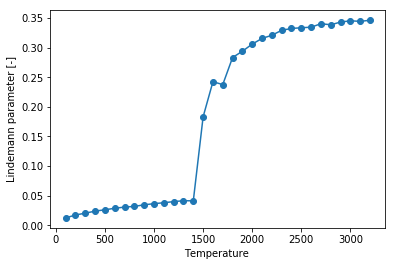

In [9]:
plt.plot(temperature_list, lindemann_values, 'o-')
plt.xlabel("Temperature ")
plt.ylabel("Lindemann parameter [-]")